In [18]:
%load_ext autoreload
%autoreload 2 
from vpot.calc import myMolecule
from vpot.calc.grids import sphericalGrid, blockGrid, pointGrid,sphericalAtomicGrid,blockAtomicGrid
from vpot.calc.potential import vpot,vBpot, vpotANC
from vpot.calc import DFTGroundState
from matplotlib import pyplot as plt
from scipy.special import erf
from scipy.optimize import minimize
from vpot.calc.grids import sphericalAtomicGrid
from psi4.driver import qcdb
from ase.data import atomic_numbers


import psi4
import numpy as np
import logging,time

plt.style.use("dark_background")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def getCoeffsAndExps(basisDict,atomType):
    out = []
    for i in basisDict["shell_map"]:
        if i[0] == atomType:
            for j in i[2:]:
                for k in j[1:]:
                    out.append(k)
    return(out)
    
def optmizeBasis(x0,Gs,atomType):
    optmizeBasis.counter+=1
    xmod = x0
    counter = 0
    
    a,newBasis = qcdb.BasisSet.pyconstruct(Gs.mol.psi4Mol.to_dict(),'BASIS', 
                                           "def2-SVP",fitrole='ORBITAL',
                                          other=None,return_dict=True,return_atomlist=False)

    for i in newBasis["shell_map"]:
        del i[2:]

    for c,i in enumerate(Gs.mol.augmentDict["shell_map"]):
        if i[0] == atomType:
            for j in i[2:]:
                newBas = []
                newBas.append(j[0])
                for k in j[1:]:
                    newBas.append((xmod[counter],xmod[counter+1]))
                    counter+=2
                newBasis["shell_map"][c] += [newBas]

    Gs.mol.setBasisDict(orbitalDict=Gs.mol.getOrbitalDict(),augmentDict=newBasis,quiet=True)
    logging.info(getCoeffsAndExps(M.basisDict,atomType))

    Gs.projectBasis()
    Vs = Gs.optimizeBasis(potentialType="anc",a=2)
    Error = Gs.getMSError(Vs)

    logging.info(f"ERROR FROM AUGMENTBASIS: {Error}")
    logging.info(getCoeffsAndExps(M.basisDict,atomType))

    if (optmizeBasis.counter %1000)==0:
        print(f"Count: {optmizeBasis.counter}, Error {Error}")
    return Error    




In [20]:
def generateS(M,nContractions,atomType):
    a,newBasis = qcdb.BasisSet.pyconstruct(M.psi4Mol.to_dict(),'BASIS', 
                                           "def2-SVP",fitrole='ORBITAL',
                                          other=None,return_dict=True,return_atomlist=False)

    
    Z = atomic_numbers[atomType]
    exps = np.linspace(1.0,10000,nContractions)
    coeffs = -(4.91186472473308*Z**2)/nContractions*np.ones(nContractions)
    
    S = [0]
    for x,y in zip(exps,coeffs):
        S.append((x,y))
    
    for i in newBasis["shell_map"]:
        del i[2:]
        
    for c,i in enumerate(newBasis["shell_map"]):
        if i[0] == atomType.upper():
            i += [S]
            
    return newBasis

            
        
    

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis set not augmented!! 

Basis set has 31 functions
Creating a spherical grid for atomtype C
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 6 functions
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 1.5, 'nRadical': 300, 'nSphere': 590, 'nPoints': 92034, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 22326701.232579153
MeanError: 242.59188161526342
MaxError : 919.2196028977376
MinError : 0.2227325723466357


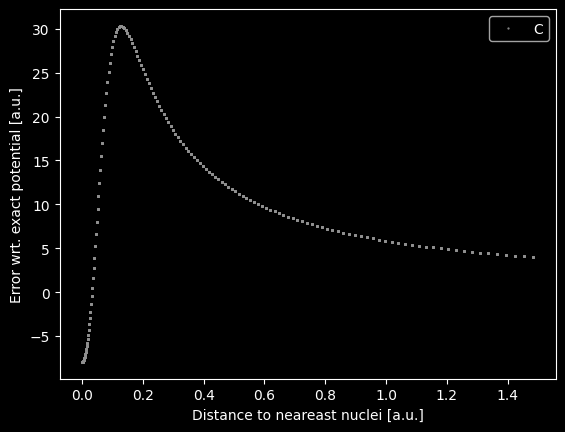

Count: 1000, Error 0.6798232634567709
Count: 2000, Error 0.42839415772581063
Count: 3000, Error 0.39062167269440234
Count: 4000, Error 0.3846363599407508
Count: 5000, Error 0.38444988337666175
Count: 6000, Error 0.3777050504986866
Count: 7000, Error 0.37202439025949063
Count: 8000, Error 0.37059314033915913
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.3705931357015386
        x: [ 1.560e+01 -5.904e+01 ...  9.908e+01 -1.346e+01]
      nit: 242
      jac: [-2.598e-06 -2.431e-06 ...  0.000e+00  0.000e+00]
     nfev: 8033
     njev: 277
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>


In [51]:
atomType = "C"
M = myMolecule("tests/C.xyz","def2-TZVP",augmentBasis=False)

aug = generateS(M,15,"C")
del aug["shell_map"][0][2]  

aug["shell_map"][0] += [[0,
(1.0,-0.22461786607341364),
(13.845568160602001,-0.30348092891692463),
(48.43242611411797,-0.36656785111004025),
(131.64974804239822,-0.0016706161320301477),
(150.6377170389632,-0.09895965089389915),
(184.25659020951073,-0.5024053313439563),
(196.25672530557276,-1.273674078159895),
],
[2,
(64.09059667065853,-44.32025397429442),
(16.361102033383844,-55.914609888605284),
(40.71101142609209,-0.8920479546367135),
(53.52932100771474,-15.110109753231313),
(66.53754476353657,-16.876741244067606),
(82.28764541343487,-15.266989642815647),
(99.07972731524194,-13.46462760006232),
]]


M.setBasisDict(orbitalDict=None,augmentDict=aug)

Gb =  sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=1.5,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)


xinit = np.array(getCoeffsAndExps(M.getAugmentDict(),atomType))
xinit = xinit.flatten()

bounds = [(1.0,100000.0) if (c%2==0) else (-1E5,0.0) for c,x in enumerate(xinit) ]

optmizeBasis.counter=0
result = minimize(optmizeBasis,xinit,args=(Gb,atomType),bounds=bounds)
print(result)



Filter: (117994, 4)
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 117994, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 176645.3687606774
MeanError: 1.497070772756898
MaxError : 7.5943051927523975
MinError : 8.023498256090233e-07


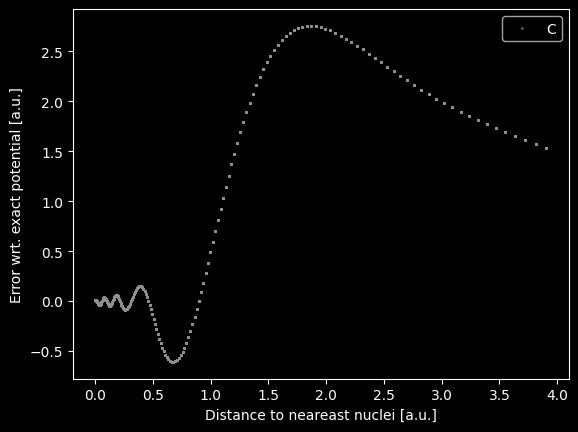

[-2.39685140e+01 -7.14746498e-18 -3.49144000e-19 -4.09729522e-34
 -1.23456213e-17 -6.98288000e-19]


{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1 entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['C',
   '72db9a94c8f274aebf4410505c2208131fe6a66b',
   [0,
    (15.597090180818915, -59.039519418279575),
    (1.0, -148.68210982655083),
    (1.0, -121.00682444134475),
    (67.48383611856131, -17.116741079835396),
    (126.53898024591065, -0.008640754121692119),
    (172.05949661157132, -0.0027410482529667424),
    (195.17843314472205, -39.32909261968386)],
   [2,
    (64.0901283961366, -44.32025629004408),
    (16.361099717345173, -55.914612204354945),
    (40.710735696782734, -0.8920502706880655),
    (53.52931869196508, -15.110112069329265),
    (66.53755814164315, -16.876738114454536),
    (82.28765126606105, -15.266986513398978),
    (99.07973044451506, -13.464625210335017)]]],
 'ad

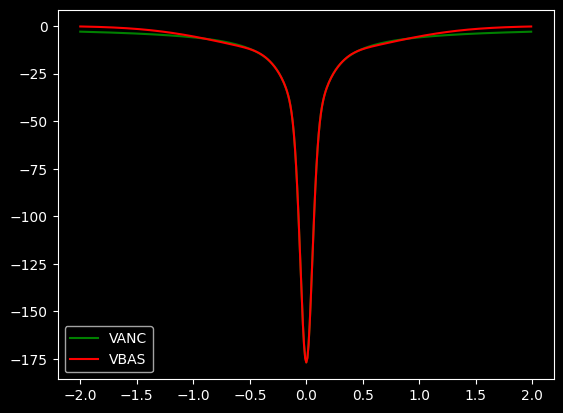

In [53]:
Gb = sphericalGrid(M,minDist=0.00,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)
print(Vb.diagonal())


L = np.array([[0.0,0.0,x] for x in np.arange(-2.0,2.0,0.01)])


GL1  = pointGrid(M,L)

VBAS = vBpot(GL1.phi,Vb.diagonal())
VANC = vpotANC(M.geom,M.elez,L,prec)

plt.plot(L[:,2],VANC,label="VANC",color="green")
plt.plot(L[:,2],VBAS,label="VBAS",color="red")
plt.legend()


Sopt = M.getAugmentDict()
Sopt

Basis string is empty
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 6 functions
Creating a spherical grid for atomtype CL
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 6 functions
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 1.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 70800, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 802065336.3592881
MeanError: 11328.606445752657
MaxError : 58984.15562074361
MinError : 2.274927066882199


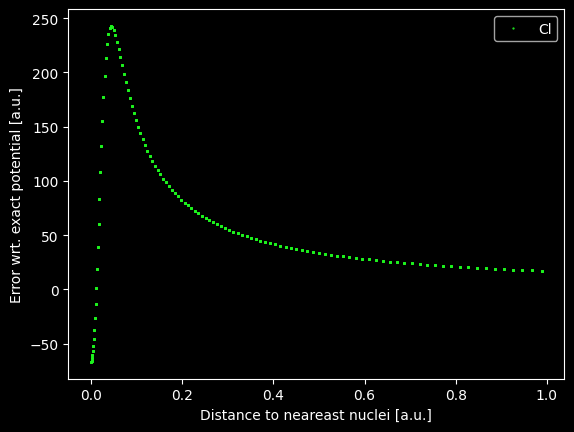

Count: 1000, Error 23.761932856956545
Count: 2000, Error 7.968047165695527
Count: 3000, Error 1.4917927344909712
Count: 4000, Error 0.5913074562021986
Count: 5000, Error 0.5571667708443907
Count: 6000, Error 0.34399037387922365
Count: 7000, Error 0.2748925409796087
Count: 8000, Error 0.27322613252668354
Count: 9000, Error 0.2597577208885552
Count: 10000, Error 0.23490894832992798
Count: 11000, Error 0.1961005347613384
Count: 12000, Error 0.19396483400240722
Count: 13000, Error 0.19384959760388695
Count: 14000, Error 0.1938335124781368
Count: 15000, Error 0.19381515162547513
Count: 16000, Error 0.19377140895389383
Count: 17000, Error 0.19357824058147996
Count: 18000, Error 0.1935723949060429
Count: 19000, Error 0.19352994072329838
Count: 20000, Error 0.1894173720128595
Count: 21000, Error 0.18836052561118066
Count: 22000, Error 0.18219023880349303
Count: 23000, Error 0.16700453383783165
Count: 24000, Error 0.16422499291491804
Count: 25000, Error 0.16417149345511925
Count: 26000, Error 0

In [61]:
nSphere = 590
nRadial = 300

atomType = "CL"
M = myMolecule("tests/Cl.xyz","")

aug = generateS(M,15,"Cl")
del aug["shell_map"][0][2]  

aug["shell_map"][0] += [[0,
(1533.1856545881196,-3.1197763073560587),
(25.638882101211305,-0.22872245488614532),
(4.320085283669779,-0.2137524302459758),
(109.5060525662482,-0.40023176125589716),
(137.77318749115,-0.025830650303751358),
(256.5467981533771,-0.18342255823211867),
(405.77918611690086,-0.47258186742197494),
],
[2,
(344.4818882226527,-4.559388973207391),
(104.57555144895815,-4.960778301954846),
(92.49917281551598,-6.257851858359405),
(1.4486146531061739,-3.2647066293307407),
(81.3007766286277,-7.935353376117609),
(85.70642385583905,-8.193208235904315),
(88.59733240545522,-8.65440225452961),
]]

M.setBasisDict(orbitalDict=M.getOrbitalDict(),augmentDict=aug)

Gs = sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=1.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
#Gs = blockAtomicGrid(M,atomType,minDist=0.1,maxDist=4.0,gridSpacing=0.1) 

Vb = Gs.optimizeBasis(potentialType="anc",a=2)

Gs.printStats(Vb,output="print")
Gs.exportErrorVsDistance(Vb)


xinit = np.array(getCoeffsAndExps(M.getAugmentDict(),atomType))
xinit = xinit.flatten()

bounds = [(1.0,100000.0) if (c%2==0) else (-1E5,0.0) for c,x in enumerate(xinit) ]

optmizeBasis.counter=0
result = minimize(optmizeBasis,xinit,args=(Gs,atomType),bounds=bounds,options={'maxfun':200000,'eps':1.0E-6})
print(result)



Filter: (109150, 4)
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 109150, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 1490535.701132473
MeanError: 13.655847009917299
MaxError : 61.958374484107686
MinError : 1.221682908380995e-05


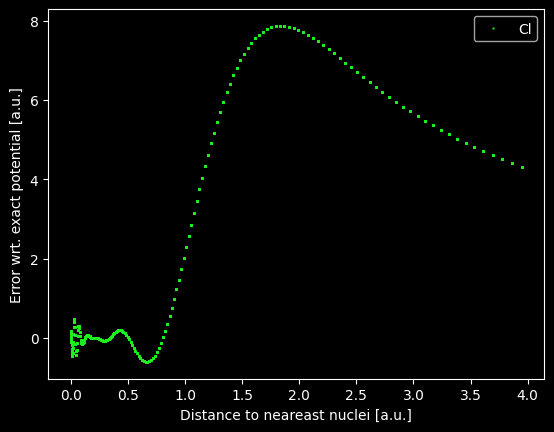

[-6.64088123e+01 -2.49005861e-19 -1.48506826e-18  9.73482682e-19
 -3.34377424e-17 -8.24338168e-19]


{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1 entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['CL',
   '3639ab98fc0f5e64dafb43e8b43524c0e027c969',
   [0,
    (1543.9221900683972, -21.22698175384103),
    (1.0, -170.21591448734964),
    (1.0, -53.75651421734891),
    (12.65824899171399, -49.53204061460531),
    (54.583988364070244, -24.381687134644128),
    (172.84236304783815, -16.144354050967234),
    (455.93387565846405, -8.390163817275575)],
   [2,
    (344.4818883040117, -4.559388760851001),
    (104.57555144895815, -4.960778540735729),
    (92.49917281551598, -6.257851858359405),
    (1.4486146531061739, -3.2647066293307407),
    (81.3007766286277, -7.935353376117609),
    (85.70642385583905, -8.193208235904315),
    (88.59733248457668, -8.654401164547483)]]],
 'additionalMess

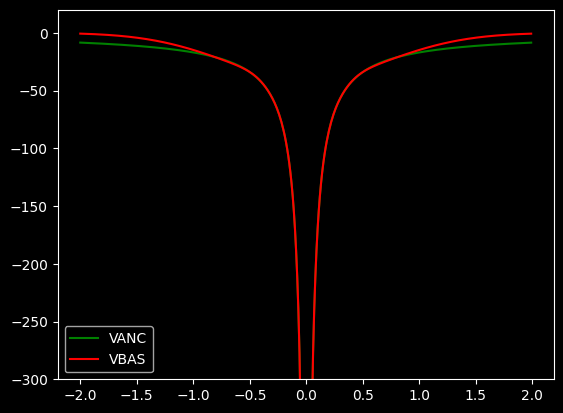

In [62]:
Gb = sphericalGrid(M,minDist=0.00,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)
print(Vb.diagonal())



L = np.array([[0.0,0.0,x] for x in np.arange(-2.0,2.0,0.01)])


GL1  = pointGrid(M,L)

VBAS = vBpot(GL1.phi,Vb.diagonal())
VANC = vpotANC(M.geom,M.elez,L,prec)

plt.plot(L[:,2],VANC,label="VANC",color="green")
plt.plot(L[:,2],VBAS,label="VBAS",color="red")
plt.legend()
plt.ylim(-300,20)


Sopt = M.getAugmentDict()
Sopt

Basis string is empty
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 6 functions
Creating a spherical grid for atomtype H
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 6 functions
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 133340, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 31838.468677646204
MeanError: 0.23877657625353385
MaxError : 0.8547656573076625
MinError : 6.000226380512759e-08


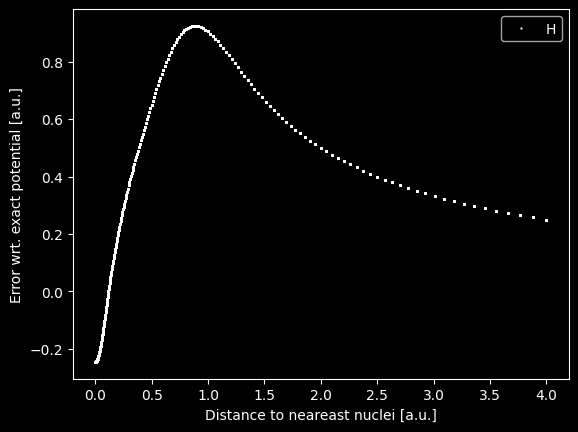

Count: 1000, Error 0.05226509493365702
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.03363336973164559
        x: [ 1.000e+00 -2.906e+01 ...  1.000e+02 -2.993e-01]
      nit: 39
      jac: [ 3.751e-02 -4.868e-08 ...  0.000e+00  0.000e+00]
     nfev: 1479
     njev: 51
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>


In [66]:
nSphere = 590
nRadial = 300

atomType = "H"
M = myMolecule("tests/H.xyz","")

aug = generateS(M,15,"H")
del aug["shell_map"][0][2]  

aug["shell_map"][0] += [[0,
(4.118247348028562,-1.2423721764962108),
(16.848073520016417,-0.044974215727207376),
(33.95550317061973,0.0),
(50.49206624127839,0.0),
(66.9964687538661,-0.0009133046758668718),
(83.49801014147027,-0.002074526335212625),
(99.99878688757941,-0.003063709884361248),
],
[2,
(1.2431320942924937,-2.7009151581420143),
(17.484024537022258,-0.8562872608243802),
(33.994199020191985,-0.5050140631872043),
(50.498087754653305,-0.37687123315123794),
(66.99925349935766,-0.3285975488912303),
(83.49967770451536,-0.30835461380677043),
(99.99985490891608,-0.29932575448194476),
]]

M.setBasisDict(orbitalDict=M.getOrbitalDict(),augmentDict=aug)

Gs = sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
#Gs = blockAtomicGrid(M,atomType,minDist=0.1,maxDist=4.0,gridSpacing=0.1) 

Vb = Gs.optimizeBasis(potentialType="anc",a=2)

Gs.printStats(Vb,output="print")
Gs.exportErrorVsDistance(Vb)


xinit = np.array(getCoeffsAndExps(M.getAugmentDict(),atomType))
xinit = xinit.flatten()

bounds = [(1.0,100000.0) if (c%2==0) else (-1E5,0.0) for c,x in enumerate(xinit) ]

optmizeBasis.counter=0
result = minimize(optmizeBasis,xinit,args=(Gs,atomType),bounds=bounds,options={'eps':1.0E-6})
print(result)

Creating a spherical grid for atomtype H
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 133340, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 4484.673520017623
MeanError: 0.03363336973164559
MaxError : 0.21132973672102787
MinError : 5.513944126878878e-09


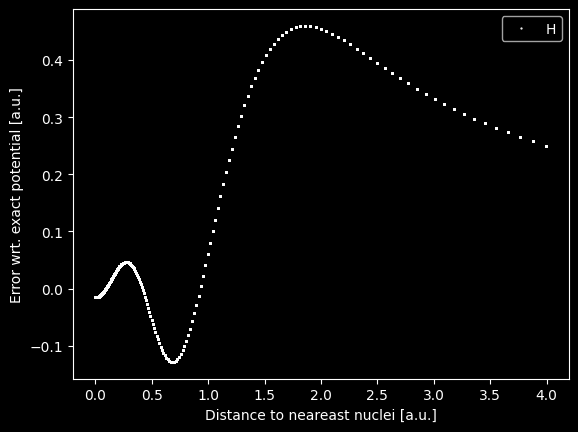

[-3.92945614e+00 -7.71962633e-19 -1.52886489e-18  3.31455157e-19
 -4.90660639e-19 -1.95442021e-18]


{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['H',
   'a6d5fb68e49b46b6bbd6220d50dcb28b38bba2ff',
   [0,
    (1.0, -29.060718623314354),
    (7.421964784960768, -6.387511601999107),
    (33.9555251459041, 0.0),
    (50.49206624127839, 0.0),
    (66.97845981662513, 0.0),
    (83.46137624647466, 0.0),
    (99.94939432276627, 0.0)],
   [2,
    (1.24313207146987, -2.7009151831356557),
    (17.48402453637462, -0.8562872896920667),
    (33.99419901903818, -0.5050140864172199),
    (50.49808775204665, -0.37687125848323766),
    (66.99925349914432, -0.3285975470762305),
    (83.49967768261936, -0.3083546136180638),
    (99.9998549102301, -0.29932477817843267)]]],
 'additionalMessage': '\nBasis set only augmented!!\n\nBasis set has 6 functions

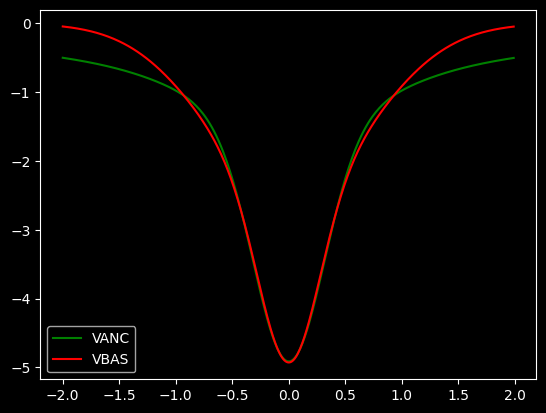

In [68]:
Gb = sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 

Vb = Gb.optimizeBasis(potentialType="anc",a=2)


Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)
print(Vb.diagonal())



L = np.array([[0.0,0.0,x] for x in np.arange(-2.0,2.0,0.01)])


GL1  = pointGrid(M,L)

VBAS = vBpot(GL1.phi,Vb.diagonal())
VANC = vpotANC(M.geom,M.elez,L,prec)

plt.plot(L[:,2],VANC,label="VANC",color="green")
plt.plot(L[:,2],VBAS,label="VBAS",color="red")
plt.legend()

Sopt = M.getAugmentDict()
Sopt


   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 116 functions
   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 92 functions
Creating a spherical grid for atomtype C
   => Loading Basis Set <=

    Name: DEF2-TZV

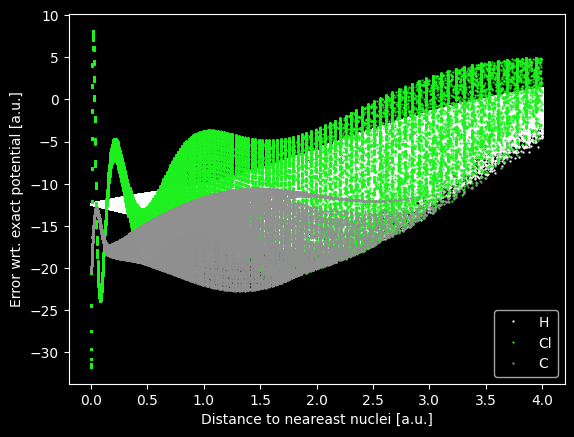

'\nxinit = np.array(getCoeffsAndExps(M.getAugmentDict(),atomType))\nxinit = xinit.flatten()\n\nbounds = [(0.1,100000.0) if (c%2==0) else (-1E5,0.0) for c,x in enumerate(xinit) ]\n\noptmizeBasis.counter=0\nresult = minimize(optmizeBasis,xinit,args=(Gb,atomType),bounds=bounds)\nprint(result)\n'

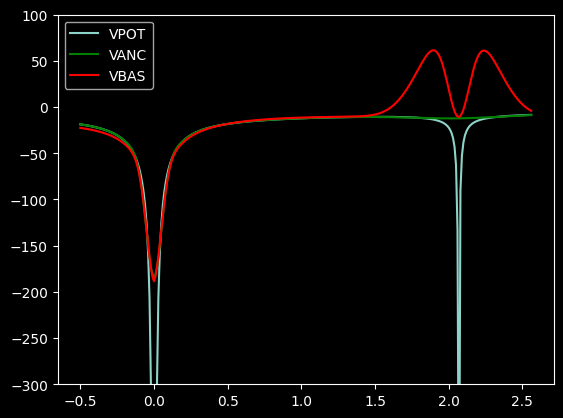

In [30]:
nSphere = 590
nRadial = 300
prec=2


atomType = "C"
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")

M.keepAugmentBasisForAtomType("C")

a,newOrb = qcdb.BasisSet.pyconstruct(M.psi4Mol.to_dict(),'BASIS',
                                            "def2-TZVP",fitrole='ORBITAL',
                                            other=None,return_dict=True,return_atomlist=False)
for i in newOrb["shell_map"]:
            del i[2:]

for c,i in enumerate(M.getOrbitalDict()["shell_map"]):
    if i[0] == atomType:
        newOrb["shell_map"][c] += i[2:]
        
M.setBasisDict(orbitalDict=newOrb,augmentDict=M.getAugmentDict())
        

Gb =  sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=2.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
V1 = Gb.optimizeBasis(potentialType="anc",a=2)


atomType = "CL"
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")

M.keepAugmentBasisForAtomType("CL")

a,newOrb = qcdb.BasisSet.pyconstruct(M.psi4Mol.to_dict(),'BASIS',
                                            "def2-TZVP",fitrole='ORBITAL',
                                            other=None,return_dict=True,return_atomlist=False)
for i in newOrb["shell_map"]:
            del i[2:]

for c,i in enumerate(M.getOrbitalDict()["shell_map"]):
    if i[0] == atomType:
        newOrb["shell_map"][c] += i[2:]
        
M.setBasisDict(orbitalDict=newOrb,augmentDict=M.getAugmentDict())
        

Gb =  sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=2.5,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
V2 = Gb.optimizeBasis(potentialType="anc",a=2)

atomType = "H"
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")

M.keepAugmentBasisForAtomType("H")

a,newOrb = qcdb.BasisSet.pyconstruct(M.psi4Mol.to_dict(),'BASIS',
                                            "def2-TZVP",fitrole='ORBITAL',
                                            other=None,return_dict=True,return_atomlist=False)
for i in newOrb["shell_map"]:
            del i[2:]

for c,i in enumerate(M.getOrbitalDict()["shell_map"]):
    if i[0] == atomType:
        newOrb["shell_map"][c] += i[2:]
        
M.setBasisDict(orbitalDict=newOrb,augmentDict=M.getAugmentDict())
        

Gb =  sphericalAtomicGrid(M,atomType,minDist=0.0,maxDist=1.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
V3 = Gb.optimizeBasis(potentialType="anc",a=2)


    


M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")
Gb =  sphericalGrid(M,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 

Vb = Gb.optimizeBasisWeights(potentialType="anc",a=2)

for c,i in enumerate(Vb.diagonal()):
    Vb[c][c] = 0.0

counter = 0
for c,i in enumerate(V1.diagonal()):
    Vb[counter][counter] = i
    counter+=1
for c,i in enumerate(V2.diagonal()):
    Vb[counter][counter] = i
    counter +=1

for c,i in enumerate(V3.diagonal()):
    Vb[counter][counter] = i
    counter +=1




Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

P1 = M.geom[0]
P2 = M.geom[2]

v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])
VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,L,prec)
GL = pointGrid(M,L)
VBAS = vBpot(GL.phi,Vb.diagonal())

plt.plot(r,VPOT,label="VPOT")
plt.plot(r,VANC,label="VANC",color="green")
plt.plot(r,VBAS,label="VBAS",color="red")
plt.legend()
plt.ylim(-300,100)
M.getAugmentDict()

"""
xinit = np.array(getCoeffsAndExps(M.getAugmentDict(),atomType))
xinit = xinit.flatten()

bounds = [(0.1,100000.0) if (c%2==0) else (-1E5,0.0) for c,x in enumerate(xinit) ]

optmizeBasis.counter=0
result = minimize(optmizeBasis,xinit,args=(Gb,atomType),bounds=bounds)
print(result)
"""

In [14]:
Vb[0][0]

-2954.1669483231285

In [23]:
a,newBas = qcdb.BasisSet.pyconstruct(Gb.mol.psi4Mol.to_dict(),'BASIS',
                                            "def2-TZVP",fitrole='ORBITAL',
                                            other=None,return_dict=True,return_atomlist=False)
for i in newBas["shell_map"]:
            del i[2:]

for c,i in enumerate(M.getBasisDict()["shell_map"]):
    if i[0] == atomType:
        newBas["shell_map"][c] += i[2:]
newBas

{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-TZVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs \n    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs \n    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-TZVP',
 'blend': 'DEF2-TZVP',
 'puream': 1,
 'shell_map': [['C', '9bf68a05e8ce164807f159c0d3b557d1e82d70b0'],
  ['CL',
   '038cdb8841cf304177b990fba4c1896ddca8b33e',
   [0,
    (1525.3301696463764, -4.329339572763802),
    (3.177987447504104, -124.64124935640007),
    (42.4070090231456, -12.65525111662699),
    (25.547440707863778, 0.0),
    (362.80814792171714, 0.0),
    (111.8303359203782, -8.766308493916176),
    (349.06960762796456, -4.531432501786144)],
   [2,
    (804.9030424119445, -3.3920919759429133),
    (0.1194311099714

In [2]:
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")
M.augmentDict

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 116 functions


{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 2   entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['C',
   '72db9a94c8f274aebf4410505c2208131fe6a66b',
   [0,
    (0.23218329211288602, -21.094809853597333),
    (1.5364075759837887, -0.03816297183434762),
    (45.13825609192154, -0.00492098655665097),
    (111.85980748258987, 0.0),
    (127.86988804492859, 0.0),
    (151.56713331540698, -0.0017385678416530275),
    (203.89443670783965, -0.020236219277979542)],
   [2,
    (0.12377608561146469, -0.11510439340129572),
    (27.306963991972644, -80.39462024303323),
    (41.39101927

In [ ]:


Dist    = np.array([np.linalg.norm(Gb.points[:,:3] - x,axis=1) for x in Gb.mol.geom]).transpose()
Dmin    = np.min(Dist,axis=1)
W =  res.x[1]*np.exp(-(Dmin*res.x[0])**2)
plt.plot(Dmin,W)

In [287]:
res.x

array([0.68574101, 0.74219284])